In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

### LOADING PROCESSED DATA

In [3]:
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '../..'))
PROCESSED_DATA_PATH = os.path.join(BASE_DIR, 'data', 'processed')

In [4]:
X_train = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, 'X_train.csv'))
X_test = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, 'X_test.csv'))
y_train = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, 'y_train.csv')).values.ravel()
y_test = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, 'y_test.csv')).values.ravel()

print(f"Data Loaded! Training Shape: {X_train.shape}")

Data Loaded! Training Shape: (5634, 30)


### HYPERPARA TUNING

In [5]:
dt = DecisionTreeClassifier(random_state=42)

# The "Grid" of options to test:
param_grid = {
    'criterion': ['gini', 'entropy'],           # The math behind the split
    'max_depth': [3, 5, 7, 10, None],           # How deep the tree can go
    'min_samples_split': [2, 5, 10],            # Minimum items to allow a split
    'min_samples_leaf': [1, 2, 4],              # Minimum items in a final leaf
    'class_weight': [None, 'balanced']          # 'balanced' helps with our Imbalanced Churn data!
}

In [6]:
print("Starting Grid Search... (finding best model settings)")

# scoring='f1' is crucial because we care about Churn (the minority class), not just accuracy
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

best_dt = grid_search.best_estimator_
print(f"\n[SUCCESS] Best Parameters Found: {grid_search.best_params_}")

Starting Grid Search... (finding best model settings)
Fitting 5 folds for each of 180 candidates, totalling 900 fits

[SUCCESS] Best Parameters Found: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}


### EVAL

In [7]:
y_pred = best_dt.predict(X_test)
y_prob = best_dt.predict_proba(X_test)[:, 1] # Probability for ROC-AUC

### A. Classification Report

In [8]:
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1035
           1       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.75      1409



In [9]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
# (Make sure you have run the y_pred = best_dt.predict(X_test) line first)
dt_accuracy = accuracy_score(y_test, y_pred)

print(f"Decision Tree Test Accuracy: {dt_accuracy:.4f}")

Decision Tree Test Accuracy: 0.7410


### B. Confusion Matrix

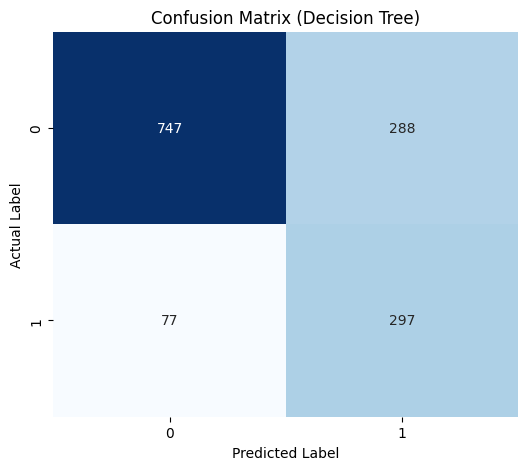

In [10]:
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Decision Tree)')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

### C. ROC-AUC Score (The Ultimate Metric)

In [11]:
auc = roc_auc_score(y_test, y_prob)
print(f"\n[COMPLETED] ROC-AUC Score: {auc:.4f}")


[COMPLETED] ROC-AUC Score: 0.8321


### DT VISUALIZATION

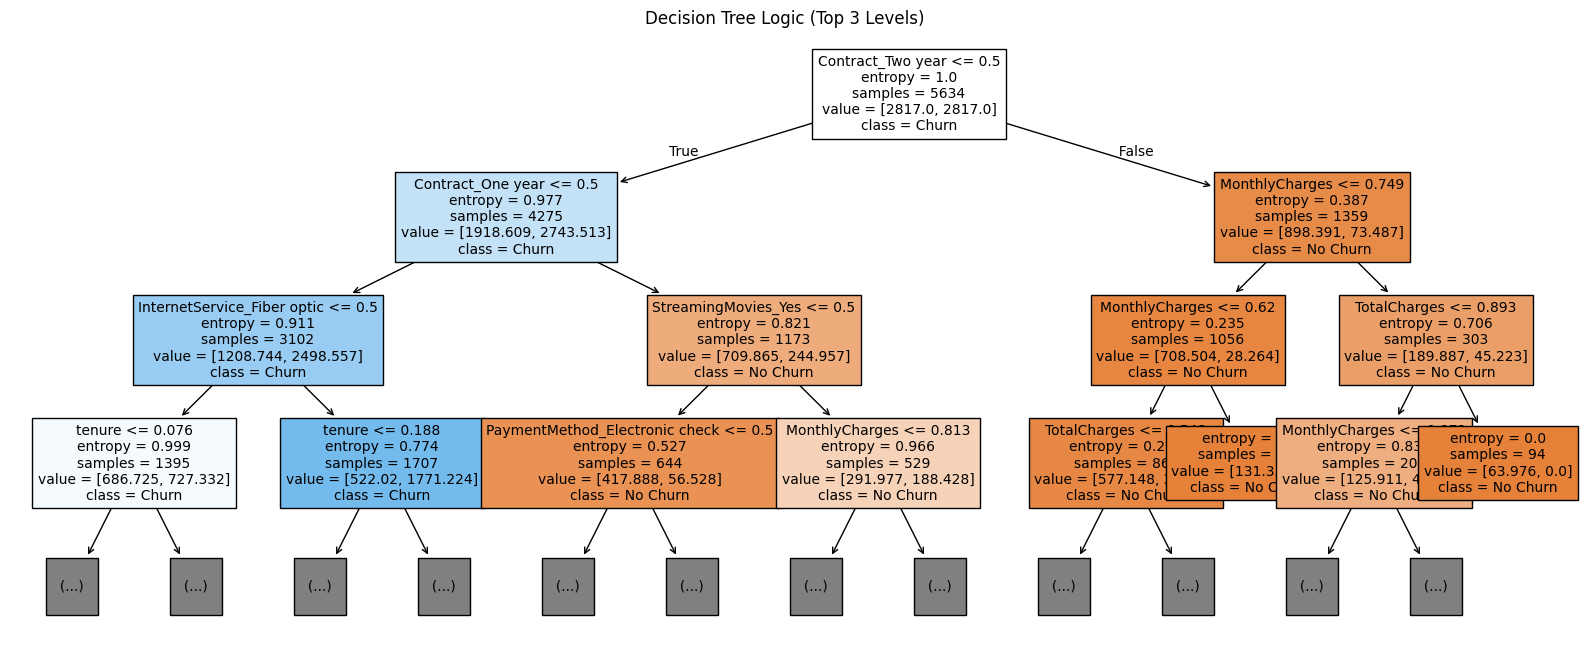

In [12]:
# visualize the top 3 levels of the tree

plt.figure(figsize=(20, 8))
plot_tree(best_dt, feature_names=X_train.columns, class_names=['No Churn', 'Churn'], 
          filled=True, max_depth=3, fontsize=10)
plt.title('Decision Tree Logic (Top 3 Levels)')
plt.show()

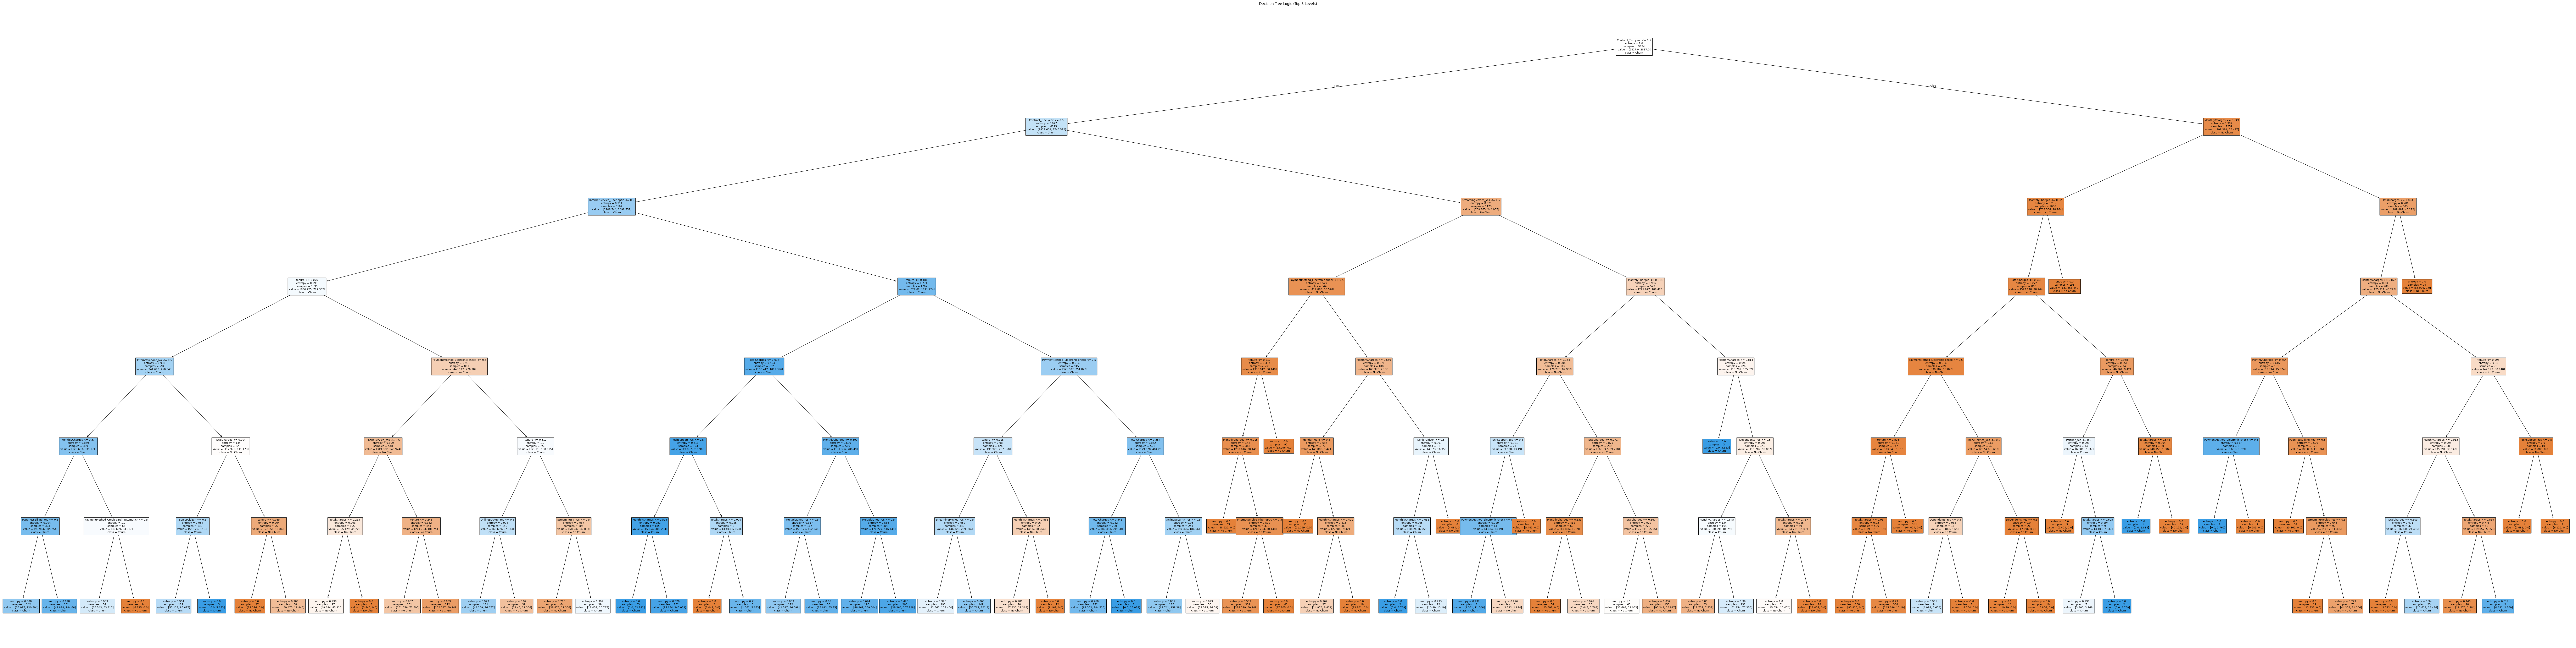

In [13]:
# visualizing the all 7 levels

plt.figure(figsize=(160, 40))
plot_tree(best_dt, feature_names=X_train.columns, class_names=['No Churn', 'Churn'], 
          filled=True, max_depth=7, fontsize=9)

plt.title('Decision Tree Logic (Top 3 Levels)')
plt.show()

### ROC CURVE VISUALIZATION

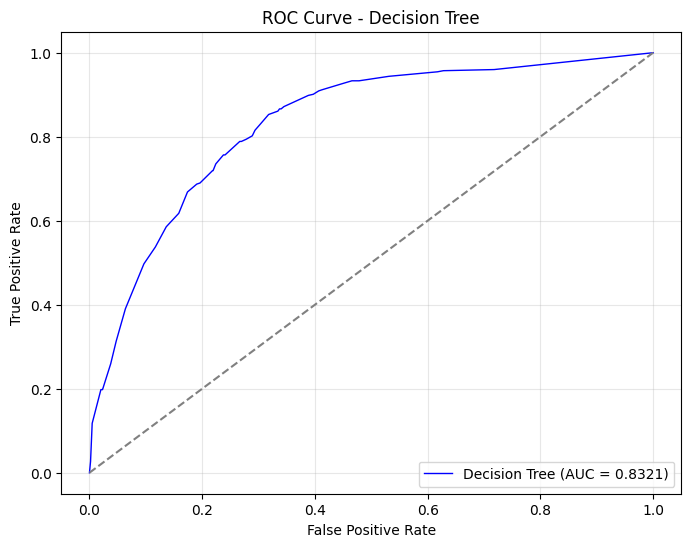

In [14]:
# getting false positive rate (fpr) and true positive rate (tpr)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))

# plot the curve
plt.plot(fpr, tpr, color='blue', lw=1, label=f'Decision Tree (AUC = {auc:.4f})')

# plot the "Random Guess" line (dashed)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

### SAVING DATA FOR COMPARISON

In [15]:
# Save probabilities for roc curve plotting
pd.DataFrame(y_prob).to_csv(os.path.join(PROCESSED_DATA_PATH, 'dt_probs.csv'), index=False)

In [16]:
import json

# calculate the specific metrics
# get F1 score specifically for "Churn" (class 1)
from sklearn.metrics import f1_score
f1_churn = f1_score(y_test, y_pred, pos_label=1)

metrics = {
    "Model": "Decision Tree",
    "Accuracy": accuracy_score(y_test, y_pred),
    "F1-Score (Churn)": f1_churn,
    "ROC-AUC": roc_auc_score(y_test, y_prob)
}

print(metrics)

# saving to JSON
import json
with open(os.path.join(PROCESSED_DATA_PATH, 'dt_metrics.json'), 'w') as f:
    json.dump(metrics, f)

print("[SUCCESS] Decision Tree metrics and probabilities exported to data/processed/")

{'Model': 'Decision Tree', 'Accuracy': 0.7409510290986515, 'F1-Score (Churn)': 0.6193952033368092, 'ROC-AUC': 0.8320855614973262}
[SUCCESS] Decision Tree metrics and probabilities exported to data/processed/
